In [51]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ['CUDA_HOME'] = '/home/jovyan/vasiliev/notebooks/Show-o/cuda_fake'
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'|

In [52]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from models import Showo
from training.prompting_utils import UniversalPrompting, create_attention_mask_predict_next
from training.utils import get_config
import json
import argparse
from PIL import Image
import numpy as np
from omegaconf import OmegaConf
from models.clip_encoder import CLIPVisionTower
from transformers import CLIPImageProcessor
from llava.llava import conversation as conversation_lib
from omegaconf import OmegaConf
from copy import deepcopy
from collections import defaultdict


conversation_lib.default_conversation = conversation_lib.conv_templates["phi1.5"]

In [53]:
from inference_mmu import run_mmu
from inference_t2i import run_t2i

In [54]:
config = OmegaConf.load('configs/showo_demo_w_clip_vit_512x512.yaml')

In [55]:
def get_model(config):
    model = Showo.from_pretrained(config.model.showo.pretrained_model_path)
    return model

In [56]:
class LayerOutputRecorder:
    def __init__(self, device='cuda', compute_stats=True):
        self.outputs = defaultdict(list)
        self.inputs_shapes = defaultdict(list)
        self.handles = []
        self.device = device
        self.compute_stats = compute_stats

    def build_hook_fn(self, name):
        def hook_fn(module, input_, output):
            with torch.no_grad():
                if self.compute_stats:
                    stats = {
                        'max_abs': output.detach().abs().max(dim=1, keepdim=False).values[0].to('cpu'),
                        # 'mean': output.mean(dim=-1),
                        # 'shape': output.shape
                    }
                    if self.device == 'cpu':
                        stats = {k: v.cpu() if isinstance(v, torch.Tensor) else v 
                                for k, v in stats.items()}
                    self.outputs[name].append(stats)
                else:
                    self.outputs[name].append(output.detach())
                    
                self.inputs_shapes[name].append(input_[0].shape)
        return hook_fn

    def register_hook(self, module_name, module):
        handle = module.register_forward_hook(self.build_hook_fn(module_name))
        self.handles.append(handle)

    def register_hooks(self, modules: list[tuple[str, torch.nn.Module]]) -> None:
        for module_name, module in modules:
            self.register_hook(module_name, module)

    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()
        self.handles = []
        
    def clear(self):
        self.outputs.clear()
        self.inputs_shapes.clear()
        torch.cuda.empty_cache()

In [57]:
def get_target_layers(model) -> list[tuple[str, torch.nn.Module]]:
    layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            layers.append((name, module))
    return layers

In [58]:
model_t2i = get_model(config)
model_mmu = get_model(config)

The config attributes {'mask_token_id': 58497} were passed to Showo, but are not expected and will be ignored. Please verify your config.json configuration file.
/home/jovyan/vasiliev/notebooks/Show-o/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


attention implementation:  sdpa


/home/jovyan/vasiliev/notebooks/Show-o/models/modeling_showo.py:49: FutureWarning: Accessing config attribute `w_clip_vit` directly via 'Showo' object attribute is deprecated. Please access 'w_clip_vit' over 'Showo's config object instead, e.g. 'unet.config.w_clip_vit'.
  if self.w_clip_vit:
The config attributes {'mask_token_id': 58497} were passed to Showo, but are not expected and will be ignored. Please verify your config.json configuration file.


attention implementation:  sdpa


In [59]:
list(model_mmu.named_modules())

[('',
  Showo(
    (showo): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(58498, 2048)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-23): 24 x PhiDecoderLayer(
            (self_attn): PhiSdpaAttention(
              (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
              (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
              (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
              (dense): Linear(in_features=2048, out_features=2048, bias=True)
              (q_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              (k_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              (rotary_emb): PhiRotaryEmbedding()
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): Linear(in_features=2048, out_features=8192, bias=True)
              (fc2):

In [60]:
target_layers_t2i = get_target_layers(model_t2i)
activations_recorder_t2i = LayerOutputRecorder()
activations_recorder_t2i.register_hooks(target_layers_t2i)

In [61]:
target_layers_mmu = get_target_layers(model_mmu)
activations_recorder_mmu = LayerOutputRecorder()
activations_recorder_mmu.register_hooks(target_layers_mmu)

In [62]:
# mode=t2i dataset.params.validation_prompts_file=validation_prompts/showoprompts.txt batch_size=1

In [63]:
# uv run inference_t2i.py config=configs/showo_demo_w_clip_vit_512x512.yaml mode=t2i dataset.params.validation_prompts_file=validation_prompts/showoprompts.txt batch_size=1

In [64]:
# uv run inference_mmu.py config=configs/showo_demo_w_clip_vit_512x512.yaml max_new_tokens=100 mmu_image_root=./mmu_validation

In [65]:
cfg = OmegaConf.load("configs/showo_demo_w_clip_vit_512x512.yaml")
# cfg.batch_size = 1
cfg.max_new_tokens = 100

cfg_mmu = deepcopy(cfg)
cfg_t2i = deepcopy(cfg)


cfg_t2i.dataset.params.validation_prompts_file="validation_prompts/text2image_prompts.txt"
cfg_t2i.mode = "t2i"
cfg_mmu.mmu_image_root = "./mmu_validation"
cfg_mmu.device = "cuda:0"
cfg_t2i.device = "cuda:0"

In [66]:
run_mmu(cfg_mmu, model_mmu)

Working with z of shape (1, 13, 16, 16) = 3328 dimensions.
Look-up free quantizer with codebook size: 8192


  0%|          | 0/6 [00:00<?, ?it/s]/home/jovyan/vasiliev/notebooks/Show-o/inference_mmu.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids).to(device).squeeze(0)
 17%|█▋        | 1/6 [00:01<00:09,  1.82s/it]

 The path or structure is on a set of train tracks that are surrounded by trees and rocks.


 33%|███▎      | 2/6 [00:09<00:21,  5.31s/it]

 The scene appears to be surreal, as it is not a typical representation of a living room or a beach setting. Instead, it features a couch, a table, and a potted plant, all placed on a beach-like surface. The couch is positioned in the middle of the scene, and the table is located to the left of the couch. The potted plant is situated to the right of the couch. The combination of these elements creates an unusual and dreamlike atmosphere, as it is


 50%|█████     | 3/6 [00:14<00:15,  5.14s/it]

 Yes, it is interacting with something or someone in the image. A dog is standing in a field of flowers, sniffing a flower, and appears to be smelling it. This suggests that the dog is curious and interested in the flower, possibly exploring its surroundings or smelling it as a part of its natural behavior.


 67%|██████▋   | 4/6 [00:15<00:07,  3.52s/it]

 The time of day in the picture is during the day.


 83%|████████▎ | 5/6 [00:16<00:02,  2.71s/it]

 The character, Spongebob, appears to be expressing happiness or excitement.


100%|██████████| 6/6 [00:18<00:00,  3.02s/it]

 The cat is walking through the snow, moving across the snow-covered ground.
=== Multimodal Understanding Results ===

Image 1: dog.png
Response: User: What kind of path or structure is it on?
 Answer :  The path or structure is on a set of train tracks that are surrounded by trees and rocks.

--------------------------------------------------

Image 2: cat.png
Response: User: Does the scene look realistic or surreal?
 Answer :  The scene appears to be surreal, as it is not a typical representation of a living room or a beach setting. Instead, it features a couch, a table, and a potted plant, all placed on a beach-like surface. The couch is positioned in the middle of the scene, and the table is located to the left of the couch. The potted plant is situated to the right of the couch. The combination of these elements creates an unusual and dreamlike atmosphere, as it is

--------------------------------------------------

Image 3: cat.txt
Response: User: Is it interacting with somethin

In [67]:
activations_recorder_mmu.outputs.keys()

dict_keys(['mm_projector.0', 'mm_projector.2', 'showo.model.layers.0.self_attn.q_proj', 'showo.model.layers.0.self_attn.k_proj', 'showo.model.layers.0.self_attn.v_proj', 'showo.model.layers.0.self_attn.dense', 'showo.model.layers.0.mlp.fc1', 'showo.model.layers.0.mlp.fc2', 'showo.model.layers.1.self_attn.q_proj', 'showo.model.layers.1.self_attn.k_proj', 'showo.model.layers.1.self_attn.v_proj', 'showo.model.layers.1.self_attn.dense', 'showo.model.layers.1.mlp.fc1', 'showo.model.layers.1.mlp.fc2', 'showo.model.layers.2.self_attn.q_proj', 'showo.model.layers.2.self_attn.k_proj', 'showo.model.layers.2.self_attn.v_proj', 'showo.model.layers.2.self_attn.dense', 'showo.model.layers.2.mlp.fc1', 'showo.model.layers.2.mlp.fc2', 'showo.model.layers.3.self_attn.q_proj', 'showo.model.layers.3.self_attn.k_proj', 'showo.model.layers.3.self_attn.v_proj', 'showo.model.layers.3.self_attn.dense', 'showo.model.layers.3.mlp.fc1', 'showo.model.layers.3.mlp.fc2', 'showo.model.layers.4.self_attn.q_proj', 'sho

In [102]:
def get_activations(recorder):
    acts_list = []
    for ind in tqdm(range(0, 24)):
        layer_name = f'showo.model.layers.{ind}.mlp.fc2'
        acts = torch.concat([a['max_abs'] for a in recorder.outputs[layer_name]], dim=0)
        print(acts)

        if len(acts) == 0:
            break

        acts_list.append(acts)
    # tens = torch.concat(acts_list, dim=0)
    # print(tens.shape)
    return acts_list

In [99]:
import matplotlib.pyplot as plt

def print_acts_boxplots(acts):
    plt.figure(figsize=(12,6))
    plt.boxplot(acts, labels=[f'Layer {i}' for i in range(len(acts))], showfliers=False)
    plt.ylabel("Activation value")
    plt.title("Boxplots of activations for different layers")
    plt.show()

In [103]:
acts_mmu = get_activations(activations_recorder_mmu)

100%|██████████| 24/24 [00:00<00:00, 842.06it/s]

tensor([1.4795, 1.6867, 2.1164,  ..., 1.3013, 1.5154, 1.5162])
tensor([1.9329, 1.6573, 9.7005,  ..., 3.2049, 3.1203, 2.0574])
tensor([1.0614, 1.7333, 5.2639,  ..., 1.0198, 1.6538, 1.1343])
tensor([1.1672, 1.5554, 5.7466,  ..., 3.5878, 2.3986, 1.7866])
tensor([1.7843, 1.8705, 1.4917,  ..., 1.4372, 1.9021, 1.4788])
tensor([2.4560, 1.4358, 2.0005,  ..., 1.5594, 2.2717, 2.9527])
tensor([3.2909, 1.9477, 2.7346,  ..., 1.9731, 1.9541, 2.1122])
tensor([2.9505, 2.8880, 1.7700,  ..., 2.1233, 1.9930, 2.0151])
tensor([1.8858, 2.3197, 1.9820,  ..., 2.3484, 2.0140, 2.4652])
tensor([3.3990, 2.5946, 3.2913,  ..., 2.1702, 2.7386, 2.6944])
tensor([3.0632, 4.3706, 3.4117,  ..., 2.8322, 4.6325, 2.3275])
tensor([2.9221, 2.6091, 2.1285,  ..., 2.4615, 2.6593, 3.2235])
tensor([3.5213, 2.8741, 2.7108,  ..., 2.1626, 2.2174, 3.0229])
tensor([2.5496, 2.2824, 2.9287,  ..., 2.6741, 3.1642, 2.9824])
tensor([2.4765, 2.9658, 2.5325,  ..., 1.7726, 2.5446, 2.9882])
tensor([2.4717, 1.9224, 2.3919,  ..., 2.4714, 1.9791, 2

In [104]:
print(acts_mmu[0])

tensor([1.4795, 1.6867, 2.1164,  ..., 1.3013, 1.5154, 1.5162])


In [106]:
len(acts_mmu)

24

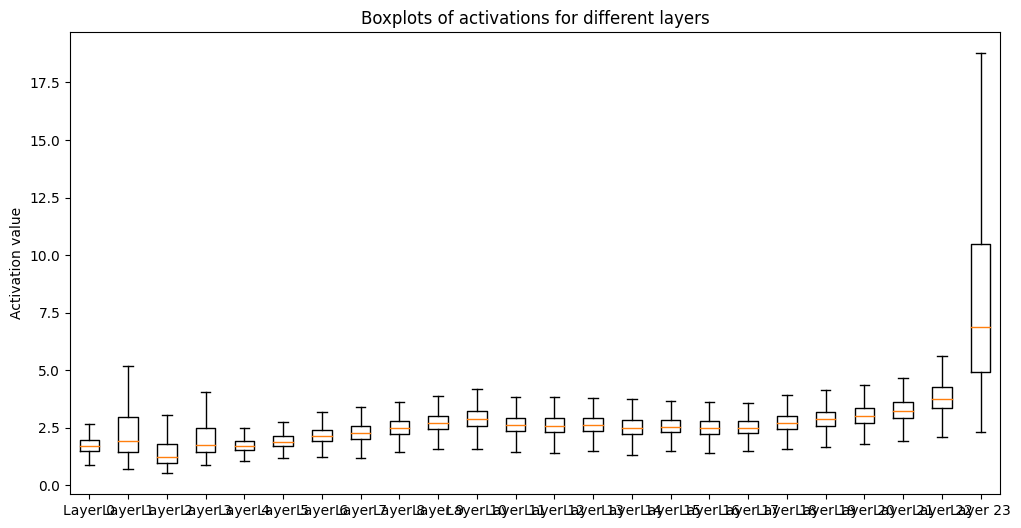

In [107]:
print_acts_boxplots(acts_mmu)

In [108]:
run_t2i(cfg_t2i, model_t2i)

Saving images to: show-o-demo/inference_t2i_20251006_193950
Working with z of shape (1, 13, 16, 16) = 3328 dimensions.
Look-up free quantizer with codebook size: 8192


100%|██████████| 1/1 [00:24<00:00, 24.85s/it]

Saved 8 text-to-image results to show-o-demo/inference_t2i_20251006_193950


In [111]:
acts_t2i = get_activations(activations_recorder_t2i)

100%|██████████| 24/24 [00:00<00:00, 2988.02it/s]

tensor([1.0004, 0.4156, 1.0055,  ..., 0.9940, 1.9848, 0.9624])
tensor([ 0.9799,  1.9946, 13.8116,  ...,  2.3381,  1.1125,  2.0763])
tensor([1.0011, 2.5977, 7.3323,  ..., 1.2555, 1.9254, 3.4686])
tensor([1.3013, 1.0833, 4.1431,  ..., 2.5917, 1.9188, 1.3386])
tensor([1.0217, 0.9965, 1.4287,  ..., 1.4174, 1.2132, 1.5113])
tensor([1.6227, 1.1004, 1.0759,  ..., 1.6615, 1.5447, 1.1968])
tensor([1.4061, 1.8292, 1.2851,  ..., 1.5797, 1.8101, 1.5858])
tensor([1.3545, 1.7823, 1.7882,  ..., 2.8593, 2.1170, 1.8896])
tensor([1.1310, 1.1100, 1.3480,  ..., 1.8431, 2.2001, 2.1396])
tensor([1.6186, 1.7195, 1.6346,  ..., 2.0986, 2.1624, 2.1433])
tensor([2.2696, 2.3608, 1.6934,  ..., 2.0723, 1.8860, 2.2723])
tensor([1.6697, 1.8960, 1.1590,  ..., 2.3872, 2.8036, 2.6508])
tensor([1.1780, 2.1712, 2.4305,  ..., 2.3062, 2.8494, 2.0387])
tensor([1.7381, 1.8583, 2.2563,  ..., 3.1858, 2.8690, 3.1846])
tensor([1.6682, 1.3072, 2.3205,  ..., 3.0243, 3.6265, 3.2190])
tensor([1.9112, 1.4654, 2.0509,  ..., 3.6094, 3.2

In [112]:
acts_t2i[0]

tensor([1.0004, 0.4156, 1.0055,  ..., 0.9940, 1.9848, 0.9624])

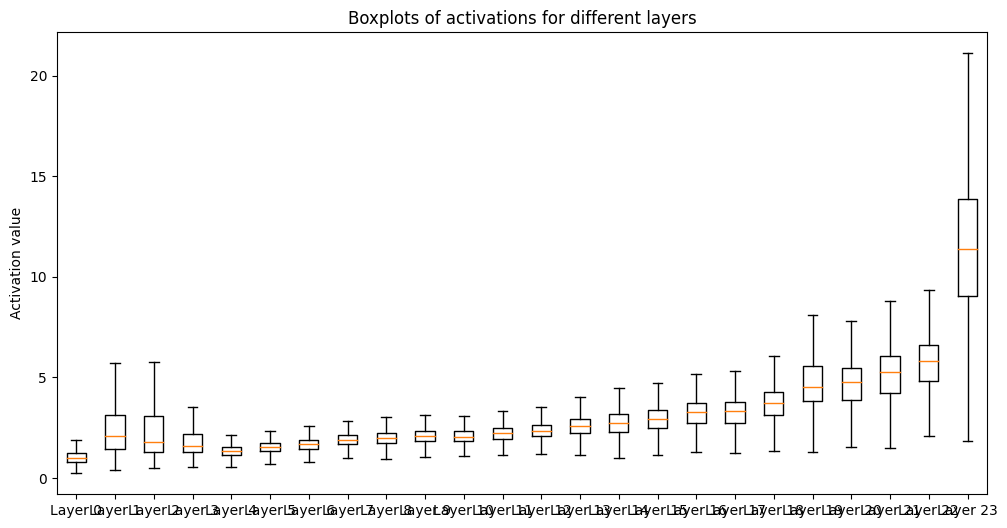

In [113]:
print_acts_boxplots(acts_t2i)